## Introdução
> O problema em questão é o modelo padrão de Buckley-Leverett, com dois fluidos incompressíveis e imiscíveis. Considerando que os fluidos são $o$ e $w$, a permeabilidade e a porosidade do meio são as funções $k(x)$ e $\phi(x)$, respectivamente, e são desprezíveis os efeitos de gravidade e capilaridade, a pressão $p$ e a saturação dos fluidos $S_w(x,t)$ e $S_o(x,t)$ são dados por um sistema combinando as equações de balanço de massa e a equação de Darcy para cada fase (Fuks e Tchelepi, 2020). A equação abaixo modela esse problema em uma dimensão:
$$\phi(x)\dfrac{\partial S_w}{\partial t} + u_{tot}\dfrac{\partial f_w(S_w)}{\partial x}=0$$.

> Na equação acima, $u_{tot}=u_w+u_o$ é a soma dos fluxos de Darcy de cada fase, e $f_w(S_w)$ é o fluxo fracional de água:
$$f_w = \dfrac{\lambda_w}{\lambda_w + \lambda_o}$$,

> Em que $\lambda_\alpha=(k\cdot k_{rw})/\mu_\alpha$ é a mobilidade de cada fase ($\alpha=o,\;w$), com $\mu_\alpha$ sendo a viscosidade da fase, e $k_{rw}(S_w)$ sendo a permeabilidade relativa de cada fase.

> Para esse problema, as equções iniciais e de fronteira são:
$$S_w(x,t)=s_{wi},\;\forall x,\; t=0\\ S_w(x,t)=s_b,\; x=0,\;t>0$$.

## Caso não-convexo sem termo difusivo - solução analítica
> O caso não-convexo também possui solução anlítica, mas, diferentemente do caso côncavo, esta possui choque, também descrita por Fuks e Tchelepi (2020):
$$u(x,t)=\left\{\begin{aligned}
& 0,& \dfrac{x}{t}>f'_w(u^*)\\
& f'^{-1}_w\left(\dfrac{x}{t}\right),& f'_w(u^*)\geq\dfrac{x}{t}\geq f'_w(u=1)\\
& 1,& f'_w(u=1)\geq\dfrac{x}{t}
\end{aligned}\right.$$

> Nessa solução, $u^*$ é a posição do choque, obtida com a condição de salto de Rankine-Hugoniot:
$$f'_w(u^*) = \dfrac{f_w(u^*) - f_w(u)|_{u=0}}{u^* - u|_{u=0}}$$

> Substituindo a função de fluxo e sua deirvada na expressão acima, obtemos:
$$\dfrac{2Mu^*(1-u^*)}{\left[(M+1)u^{*2} -2u^* +1\right]^2} = \dfrac{u^{*2}}{u^{*2} + \dfrac{(1-u^*)^2}{M}}\cdot\dfrac{1}{u^*}$$

> Com alguma manipulação algébrica, e excluindo-se a solução $u^*=0$, obtemos:
$$(M^2+2M+1)u^{*4} +(-2M-2)u^{*3} +2u^* -1 =0$$

> Resolvendo essa equação polinomial, e excluindo as soluções complexas ou com $u^*<0$ e $M\leq0$, encontra-se uma única solução, dependente de M, para a posição do choque:
$$u^* = \dfrac{1}{\sqrt{M+1}}$$

> Além disso, na solução acima, $u(x,t)$ está definido em $u*\leq u<1$ pela função $f'^{-1}_w(x/t)$, que é a função inversa da primeira derivada da função de fluxo, em função da vriável de similaridade $x/t$. Por ser relativamente complexa, ela pode ser calculada numericamente no _python_ com funções de otimização (aqui foi utilizada a função _scipy.optimize.newton_). É importante notar que o resultado da avaliação numérica da função inversa depende muito do chute inicial, e, nesse caso, um chute inicial entre $u^*$ e 1, pois a natureza não-injetora de $f'_w$ faz com que haja sempre duas soluções possíveis para $f'^{-1}_w(x/t)$: uma solução menor e outra menor ou igual a $u^*$, sendo apenas a última parte da solução da PDE.

>Para estes trabalho vamos tentar aproximar a solucao analitica do caso não-convexo sem difusão utilizando um modelo data driven de DeepONet, que é apresentado no paper: https://www.science.org/doi/10.1126/sciadv.abi8605, onde os autores aproximam diferentes tipos de equacoes diferencias utilizando DeepONets e PINNs.

>Os datasets foram criados utilizando os modelos analiticos desenvolvidos no proprio curso. O codigo foi modificado para atender as necessidades desses novos datasets e plataforma utilizada para execucao foi o Colab.

>Apesar dos bons resultados apresentados no papar, como é possivel observar na seccao de resultados, o modelo de DeepOnet não foi capaz de se adaptar ao caso do escoamento pososo com fluxo não-convexo sem difusão. Apesar da funcao perda estar sendo minimizada, o modelo não consegue aproximar a resposta desejada. Mais testes devem ser feitos para compreender este fenomeno.

In [67]:
import numpy as onp
import scipy.io
from scipy.interpolate import griddata
import jax.numpy as np
from jax import random, grad, vmap, jit
from jax.experimental import optimizers
from jax.config import config
from jax.flatten_util import ravel_pytree
from jax.nn import relu, elu
import itertools
from functools import partial
from torch.utils import data
from tqdm import trange
import matplotlib.pyplot as plt

%matplotlib inline

In [68]:
# Define modified MLP
def modified_MLP(layers, activation=relu):
  def xavier_init(key, d_in, d_out):
      glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
      W = glorot_stddev * random.normal(key, (d_in, d_out))
      b = np.zeros(d_out)
      return W, b

  def init(rng_key):
      U1, b1 =  xavier_init(random.PRNGKey(12345), layers[0], layers[1])
      U2, b2 =  xavier_init(random.PRNGKey(54321), layers[0], layers[1])
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          W, b = xavier_init(k1, d_in, d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return (params, U1, b1, U2, b2) 

  def apply(params, inputs):
      params, U1, b1, U2, b2 = params
      U = activation(np.dot(inputs, U1) + b1)
      V = activation(np.dot(inputs, U2) + b2)
      for W, b in params[:-1]:
          outputs = activation(np.dot(inputs, W) + b)
          inputs = np.multiply(outputs, U) + np.multiply(1 - outputs, V) 
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply


In [69]:
# Data generator
class DataGenerator(data.Dataset):
    def __init__(self, u, y, s, 
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u
        self.y = y
        self.s = s
        
        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs = self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        s = self.s[idx,:]
        y = self.y[idx,:]
        u = self.u[idx,:]
        # Construct batch
        inputs = (u, y)
        outputs = s
        return inputs, outputs

In [70]:
# Define Physics-informed DeepONet model
class PI_DeepONet:
    def __init__(self, branch_layers, trunk_layers):    
        # Network initialization and evaluation functions
        self.branch_init, self.branch_apply = modified_MLP(branch_layers, activation=np.tanh)
        self.trunk_init, self.trunk_apply = modified_MLP(trunk_layers, activation=np.tanh)

        # Initialize
        branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
        trunk_params = self.trunk_init(rng_key = random.PRNGKey(4321))
        params = (branch_params, trunk_params)

        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(optimizers.exponential_decay(1e-3, 
                                                                      decay_steps=2000, 
                                                                      decay_rate=0.9))
        self.opt_state = self.opt_init(params)

        # Used to restore the trained model parameters
        _, self.unravel_params = ravel_pytree(params)

        # Logger
        self.itercount = itertools.count()
        self.loss_log = []
        self.loss_ics_log = []
        self.loss_bcs_log = []
        self.loss_res_log = []

    # Define DeepONet architecture
    def operator_net(self, params, u, t, x):
        branch_params, trunk_params = params
        y = np.stack([t,x])
        B = self.branch_apply(branch_params, u)
        T = self.trunk_apply(trunk_params, y)
        outputs = np.sum(B * T)
        return   outputs
    
    # Define ds/dx
    def s_x_net(self, params, u, t, x):
         s_x = grad(self.operator_net, argnums=3)(params, u, t, x)
         return s_x

    # Define PDE residual        
    def residual_net(self, params, u, t, x):
        s = self.operator_net(params, u, t, x)
        s_t = grad(self.operator_net, argnums=2)(params, u, t, x)
        s_x = grad(self.operator_net, argnums=3)(params, u, t, x)
        s_xx= grad(grad(self.operator_net, argnums=3), argnums=3)(params, u, t, x)

        res = s_t + s * s_x - 0.01 * s_xx
        return res

    # Define initial loss
    def loss_ics(self, params, batch):
        # Fetch data
        inputs, outputs = batch
        u, y = inputs

        # Compute forward pass
        s_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])

        # Compute loss
        loss = np.mean((outputs.flatten() - s_pred)**2)
        return loss

    # Define boundary loss
    def loss_bcs(self, params, batch):
        # Fetch data
        inputs, outputs = batch
        u, y = inputs

        # Compute forward pass
        s_bc1_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])
        s_bc2_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, u, y[:,2], y[:,3])

        s_x_bc1_pred = vmap(self.s_x_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])
        s_x_bc2_pred = vmap(self.s_x_net, (None, 0, 0, 0))(params, u, y[:,2], y[:,3])

        # Compute loss
        loss_s_bc = np.mean((s_bc1_pred - s_bc2_pred)**2)
        loss_s_x_bc = np.mean((s_x_bc1_pred - s_x_bc2_pred)**2)

        return loss_s_bc + loss_s_x_bc

    # Define residual loss
    def loss_res(self, params, batch):
        # Fetch data
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        pred = vmap(self.residual_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])

        # Compute loss
        loss = np.mean((outputs.flatten() - pred)**2)
        return loss    

    # Define total loss
    def loss(self, params, ics_batch, bcs_batch, res_batch):
        loss_ics = self.loss_ics(params, ics_batch)
        loss_bcs = self.loss_bcs(params, bcs_batch)
        loss_res = self.loss_res(params, res_batch)
        loss =  20 * loss_ics + loss_bcs +  loss_res
        return loss

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, ics_batch, bcs_batch, res_batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, ics_batch, bcs_batch, res_batch)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, ics_dataset, bcs_dataset, res_dataset, nIter = 10000):
        ics_data = iter(ics_dataset)
        bcs_data = iter(bcs_dataset)
        res_data = iter(res_dataset)

        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Fetch data
            ics_batch= next(ics_data)
            bcs_batch= next(bcs_data)
            res_batch = next(res_data)

            self.opt_state = self.step(next(self.itercount), self.opt_state, ics_batch, bcs_batch, res_batch)
            
            if it % 100 == 0:
                params = self.get_params(self.opt_state)

                # Compute losses
                loss_value = self.loss(params, ics_batch, bcs_batch, res_batch)
                loss_ics_value = self.loss_ics(params, ics_batch)
                loss_bcs_value = self.loss_bcs(params, bcs_batch)
                loss_res_value = self.loss_res(params, res_batch)

                # Store losses
                self.loss_log.append(loss_value)
                self.loss_ics_log.append(loss_ics_value)
                self.loss_bcs_log.append(loss_bcs_value)
                self.loss_res_log.append(loss_res_value)

                # Print losses
                pbar.set_postfix({'Loss': loss_value, 
                                  'loss_ics' : loss_ics_value,
                                  'loss_bcs' : loss_bcs_value, 
                                  'loss_physics': loss_res_value})
           
    # Evaluates predictions at test points  
    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, U_star, Y_star):
        s_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, U_star, Y_star[:,0], Y_star[:,1])
        return s_pred

    @partial(jit, static_argnums=(0,))
    def predict_res(self, params, U_star, Y_star):
        r_pred = vmap(self.residual_net, (None, 0, 0, 0))(params, U_star, Y_star[:,0], Y_star[:,1])
        return r_pred

In [71]:
# Geneate ics training data corresponding to one input sample
def generate_one_ics_training_data(key, u0, m=101, P=101):

    t_0 = np.zeros((P,1))
    x_0 = np.linspace(0, 1, P)[:, None]

    y = np.hstack([t_0, x_0])
    u = np.tile(u0, (P, 1))
    s = u0

    return u, y, s

# Geneate bcs training data corresponding to one input sample
def generate_one_bcs_training_data(key, u0, m=101, P=100):

    t_bc = random.uniform(key, (P,1))
    x_bc1 = np.zeros((P, 1))
    x_bc2 = np.ones((P, 1))
  
    y1 = np.hstack([t_bc, x_bc1])  # shape = (P, 2)
    y2 = np.hstack([t_bc, x_bc2])  # shape = (P, 2)

    u = np.tile(u0, (P, 1))
    y =  np.hstack([y1, y2])  # shape = (P, 4)
    s = np.zeros((P, 1))

    return u, y, s

# Geneate res training data corresponding to one input sample
def generate_one_res_training_data(key, u0, m=101, P=1000):

    subkeys = random.split(key, 2)
   
    t_res = random.uniform(subkeys[0], (P,1))
    x_res = random.uniform(subkeys[1], (P,1))

    u = np.tile(u0, (P, 1))
    y =  np.hstack([t_res, x_res])
    s = np.zeros((P, 1))

    return u, y, s

# Geneate test data corresponding to one input sample
def generate_one_test_data(idx,usol, m=101, P=101):

    u = usol[idx]
    u0 = u[0,:]

    t = np.linspace(0, 1, P)
    x = np.linspace(0, 1, P)
    T, X = np.meshgrid(t, x)

    s = u.T.flatten()
    u = np.tile(u0, (P**2, 1))
    y = np.hstack([T.flatten()[:,None], X.flatten()[:,None]])

    return u, y, s 

# Geneate training data corresponding to N input sample
def compute_error(idx, usol, m, P):
    u_test, y_test, s_test = generate_one_test_data(idx, usol, m, P)

    u_test = u_test.reshape(P**2,-1)  
    y_test = y_test.reshape(P**2,-1)
    s_test = s_test.reshape(P**2,-1)

    s_pred = model.predict_s(params, u_test, y_test)[:,None]
    error = np.linalg.norm(s_test - s_pred) / np.linalg.norm(s_test) 

    return error  

In [72]:
# Prepare the training data

# Load data
path = 'fuk.mat'  # Please use the matlab script to generate data

data = scipy.io.loadmat(path)
usol = np.array( data['output'])

N = usol.shape[0]  # number of total input samples
N_train =1      # number of input samples used for training
N_test = N - N_train  # number of input samples used for test
m = 101            # number of sensors for input samples
P_ics_train = 101   # number of locations for evulating the initial condition
P_bcs_train = 100    # number of locations for evulating the boundary condition
P_res_train = 2500   # number of locations for evulating the PDE residual
P_test = 101        # resolution of uniform grid for the test data

u0_train = usol[:N_train,0,:]   # input samples
# usol_train = usol[:N_train,:,:]

key = random.PRNGKey(0) # use different key for generating test data 
keys = random.split(key, N_train)

# Generate training data for inital condition
u_ics_train, y_ics_train, s_ics_train = vmap(generate_one_ics_training_data,in_axes=(0, 0, None, None))(keys, u0_train, m, P_ics_train)

u_ics_train = u_ics_train.reshape(N_train * P_ics_train,-1)  
y_ics_train = y_ics_train.reshape(N_train * P_ics_train,-1)
s_ics_train = s_ics_train.reshape(N_train * P_ics_train,-1)

# Generate training data for boundary condition
u_bcs_train, y_bcs_train, s_bcs_train = vmap(generate_one_bcs_training_data, in_axes=(0, 0, None, None))(keys, u0_train, m, P_bcs_train)

u_bcs_train = u_bcs_train.reshape(N_train * P_bcs_train,-1)  
y_bcs_train = y_bcs_train.reshape(N_train * P_bcs_train,-1)
s_bcs_train = s_bcs_train.reshape(N_train * P_bcs_train,-1)

# Generate training data for PDE residual
u_res_train, y_res_train, s_res_train = vmap(generate_one_res_training_data, in_axes=(0, 0, None, None))(keys, u0_train, m, P_res_train)

u_res_train = u_res_train.reshape(N_train * P_res_train,-1)  
y_res_train = y_res_train.reshape(N_train * P_res_train,-1)
s_res_train = s_res_train.reshape(N_train * P_res_train,-1)

In [73]:
# Initialize model
branch_layers = [m, 100, 100, 100, 100, 100, 100, 100]
trunk_layers =  [2, 100, 100, 100, 100, 100, 100, 100]
model = PI_DeepONet(branch_layers, trunk_layers)

In [84]:
# Create data set
batch_size = 100
ics_dataset = DataGenerator(u_ics_train, y_ics_train, s_ics_train, batch_size)
bcs_dataset = DataGenerator(u_bcs_train, y_bcs_train, s_bcs_train, batch_size)
res_dataset = DataGenerator(u_res_train, y_res_train, s_res_train, batch_size)

In [85]:
# Train
# Note: may meet OOM issue if use Colab. Please train this model on the server.  
model.train(ics_dataset, bcs_dataset, res_dataset, nIter=100000)

100%|██████████| 100000/100000 [26:54<00:00, 61.96it/s, Loss=0.00087403966, loss_ics=9.165434e-06, loss_bcs=0.0006387674, loss_physics=5.196359e-05]


In [86]:
# Restore the trained model
params = model.get_params(model.opt_state)

# lam = 20
# params = model.unravel_params(np.load('modified_MLP_lam_{}_params.npy'.format(lam)))

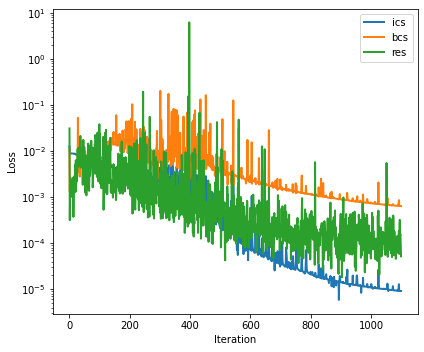

In [87]:
# Plot for loss function
plt.figure(figsize = (6,5))
# plt.plot(model.loss_log, lw=2)
plt.plot(model.loss_ics_log, lw=2, label='ics')
plt.plot(model.loss_bcs_log, lw=2, label='bcs')
plt.plot(model.loss_res_log, lw=2, label='res')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

error_s: 1.003e+00


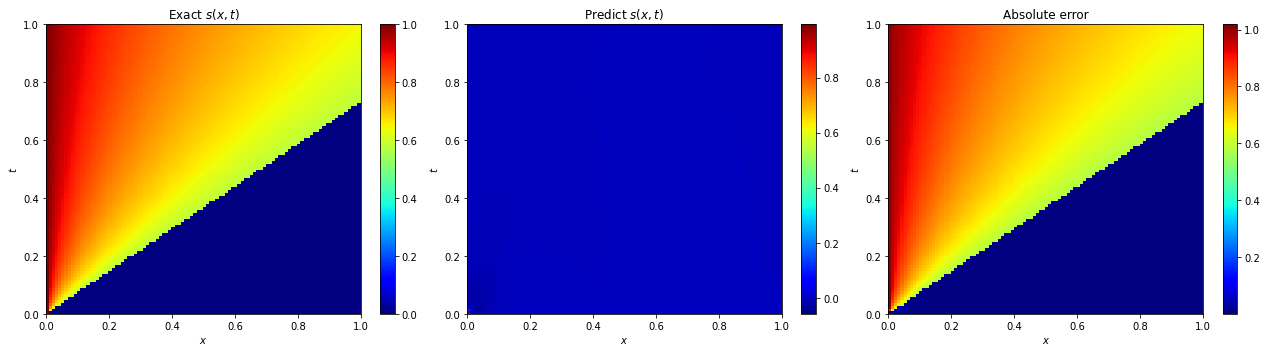

In [88]:
# Plot for one generated data
k = 0 # index
u = usol[k,:, :]
u0 = usol[k,0,:]

P_test = 101

t = np.linspace(0, 1, P_test)
x = np.linspace(0, 1, P_test)
T, X = np.meshgrid(t, x)

u_test = np.tile(u0, (P_test**2, 1))
y_test = np.hstack([T.flatten()[:,None], X.flatten()[:,None]])
s_test = u.flatten()[:,None]

s_pred = model.predict_s(params, u_test, y_test)[:,None]
S_pred = griddata(y_test, s_pred.flatten(), (T, X), method='cubic')


error_s = np.linalg.norm(u - S_pred.T, 2) / np.linalg.norm(u, 2) 

print("error_s: {:.3e}".format(error_s))

fig = plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.pcolor(T, X, u, cmap='jet')
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Exact $s(x,t)$')
plt.colorbar()
plt.tight_layout()

plt.subplot(1,3,2)
plt.pcolor(T, X, S_pred.T, cmap='jet')
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Predict $s(x,t)$')
plt.colorbar()
plt.tight_layout()

plt.subplot(1,3,3)
plt.pcolor(T, X, np.abs(S_pred.T - u), cmap='jet')
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Absolute error')
plt.colorbar()
plt.tight_layout()
plt.show()